In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import os
import warnings
warnings.filterwarnings('ignore')

from action_detail_category import detail ## action_detail 분류 py

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False ## 마이너스 부호 깨짐 방지

pd.set_option('display.max_columns', None)                       # 출력할 열의 최대개수
pd.set_option('display.max_colwidth', None)                      # 출력할 열의 너비
pd.set_option('display.unicode.east_asian_width', True) 

In [2]:
import psycopg2
import pandas.io.sql as sqlio
import math

# Redshift connection 함수
def get_Redshift_connection(autocommit):
    host={호스트명}
    redshift_user = {사용자명}
    redshift_pass = {비밀번호}
    port = 5439
    dbname = "airbnb"
    conn = psycopg2.connect("dbname={dbname} user={user} host={host} password={password} port={port}".format(
        dbname=dbname,
        user=redshift_user,
        password=redshift_pass,
        host=host,
        port=port
    ))
    conn.set_session(autocommit=autocommit)
    return conn

In [15]:
## Redshift 연결
conn = get_Redshift_connection(True)
cur = conn.cursor()

### 컬럼 설명
### train_users_2.csv
- id : 사용자 아이디
- date_account_created: 계정 생성 날짜
- timestamp_first_active: 첫 번째 활동의 타임스탬프입니다. 사용자가 가입하기 전에 검색할 수 있으므로 date_account_created 또는 date_first_booking보다 이전일 수 있습니다.
- date_first_booking: 첫 예약 날짜
- 성별
- 나이
- signup_method - 가입_방법
- signup_flow: 사용자가 가입하기 위해 온 페이지
- language: 국제 언어 기본 설정
- affili_channel: 유료 마케팅의 종류
- affiliate_provider: 마케팅이 이루어지는 곳. 구글, 크레이그리스트, 기타
- first_affiliate_tracked: 가입하기 전에 사용자가 처음으로 상호작용한 마케팅은 무엇입니까?
- signup_app - 가입_앱
- first_device_type - 첫 번째_장치_유형
- first_browser - 첫 번째_브라우저
- country_destination: 예측할 대상 변수입니다.
### session.csv - 사용자에 대한 웹 세션 로그
- user_id: users 테이블의 'id' 컬럼과 조인됩니다.
- action - 행동 
- action_type
- action_detail - 액션_디테일
- device_type - 기기 종류
- secs_elapsed - 초_경과 
#### country.csv - 이 데이터세트의 목적지 국가와 해당 위치에 대한 요약 통계
#### age_gender_bkts.csv - 사용자의 연령대, 성별, 목적지 국가에 대한 요약 통계
#### Sample_submission.csv - 예측 제출을 위한 올바른 형식

In [3]:
## sessions
sql = """SELECT * FROM raw_data.sessions"""
sessions = sqlio.read_sql_query(sql, conn)
sessions

,user_id,action,action_type,action_detail,device_type,secs_elapsed,idx
0,d1mm9tcy42,lookup,,,Windows Desktop,319.0,0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0,1
2,d1mm9tcy42,lookup,,,Windows Desktop,301.0,2
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0,3
4,d1mm9tcy42,lookup,,,Windows Desktop,435.0,4
...,...,...,...,...,...,...,...
10567732,gk11y5aule,populate_help_dropdown,-unknown-,-unknown-,Windows Desktop,12771.0,10076298
10567733,gk11y5aule,index,view,view_search_results,Windows Desktop,754.0,10076299
10567734,gk11y5aule,personalize,data,wishlist_content_update,Windows Desktop,1065.0,10076300
10567735,gk11y5aule,index,view,view_search_results,Windows Desktop,10558.0,10076301


In [4]:
## 세션 데이터 정렬
sessions.sort_values(by='idx', inplace=True)

sessions.reset_index(drop=True, inplace=True)
sessions.drop(columns=['idx'], inplace=True)

In [5]:
sessions

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,,,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,,,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,,,Windows Desktop,435.0
...,...,...,...,...,...,...
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624.0


In [4]:
sessions['action'].replace('-unknown-', 'unknown', inplace=True)
sessions['action_type'].replace('-unknown-', 'unknown', inplace=True)
sessions['action_detail'].replace('-unknown-', 'unknown', inplace=True)
sessions['device_type'].replace('-unknown-', 'unknown', inplace=True)

In [5]:
sessions['action'].fillna('error', inplace=True)
sessions['action_type'].fillna('unknown', inplace=True)
sessions['action_detail'].fillna('unknown', inplace=True)

### secs_elapsed 정렬

In [6]:
# 한 칸씩 위로 당겨오기
sessions['secs_elapsed'] = sessions['secs_elapsed'].shift(-1)

# 유저별 마지막 elapsed time은 측정되지 않았으므로 nan
last_order = sessions.groupby('user_id').tail(1).index
sessions.loc[last_order, 'secs_elapsed'] = np.NaN

In [7]:
sessions['user_flow'] = sessions['action'].astype('str') + '+' + sessions['action_type'].astype('str') + '+' + sessions['action_detail'].astype('str')

In [16]:
## train_users_2
sql = """SELECT * FROM raw_data.train_users_2"""
train = sqlio.read_sql_query(sql, conn)
train.rename(columns={'id':'user_id'},inplace=True)
train

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,,-unknown-,,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
2,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
3,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
4,a1vcnhxeij,2010-01-04,20100104004211,2010-07-29,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,rf0ay567js,2014-06-30,20140630235309,,-unknown-,,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Chrome,NDF
213447,40o1ivh6cb,2014-06-30,20140630235352,,-unknown-,,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,zxodksqpep,2014-06-30,20140630235636,,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213449,6o3arsjbb4,2014-06-30,20140630235754,,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF


### timestamp_first_active ->  datetime 타입 변환

In [7]:
train['timestamp_first_active'] = pd.to_datetime(train['timestamp_first_active'], format = '%Y%m%d%H%M%S').dt.strftime('%Y-%m-%d')
train['timestamp_first_active'] = pd.to_datetime(train['timestamp_first_active'])
train['date_account_created'] = pd.to_datetime(train['date_account_created'])
train['date_first_booking'] = pd.to_datetime(train['date_first_booking'], errors='coerce')

In [8]:
train['gender'].replace('-unknown-', 'unknown', inplace=True)
train['first_browser'].replace('-unknown-', 'unknown', inplace=True)

train['first_affiliate_tracked'].fillna('untracked', inplace=True)

In [9]:
train.isnull().sum()

user_id                         0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                             0
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked         0
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

### 사용자 데이터와 동일한 ID만 남긴 세션 생성 
- 고유 사용자는 73815명

In [10]:
# 분석을 진행할 비율
mask = sessions['user_id'].isin(train['user_id'])

## session에 포함된 user로 구성 (중복 x)
new_sessions = sessions[mask]
new_sessions.reset_index(drop=True, inplace=True)

In [11]:
## action_detail 분류 진행
new_sessions = detail(new_sessions)
new_sessions

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,,,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,,,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,,,Windows Desktop,435.0
...,...,...,...,...,...,...
5537952,nw9fwlyb5f,index,data,booking,iPhone,245.0
5537953,nw9fwlyb5f,unavailabilities,data,view_search,iPhone,286.0
5537954,nw9fwlyb5f,notifications,submit,view_search,iPhone,830.0
5537955,nw9fwlyb5f,search,click,view_search,iPhone,101961.0


### 사용자 데이터 + 세션 데이터 병합 시 고유 사용자는 73815명

In [12]:
len(new_sessions['user_id'].unique())

73815

In [13]:
df = pd.merge(new_sessions, train, on='user_id', how='inner')
df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,d1mm9tcy42,lookup,,,Windows Desktop,319.0,2014-01-01,2014-01-01,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
1,d1mm9tcy42,search_results,click,view_search,Windows Desktop,67753.0,2014-01-01,2014-01-01,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
2,d1mm9tcy42,lookup,,,Windows Desktop,301.0,2014-01-01,2014-01-01,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
3,d1mm9tcy42,search_results,click,view_search,Windows Desktop,22141.0,2014-01-01,2014-01-01,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
4,d1mm9tcy42,lookup,,,Windows Desktop,435.0,2014-01-01,2014-01-01,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other


In [16]:
len(df['user_id'].unique())

73815

# 예약 (1)  vs 비예약 (0) 구분

In [17]:
df['binary_target'] = df['country_destination'].replace({'NDF': 0}, inplace=False)
df.loc[df['binary_target'] != 0, 'binary_target'] = 1

## Train에 존재하는 session 

In [43]:
# 분석을 진행할 비율
mask = sessions['user_id'].isin(df['user_id'])

## session에 포함된 user로 구성 (중복 x)
new_sessions = sessions[mask]
new_sessions.reset_index(drop=True, inplace=True)

In [45]:
len(new_sessions['user_id'].unique())

73815

## 사용자의 액션 플로우 
- 첫 행동
- 마지막 행동

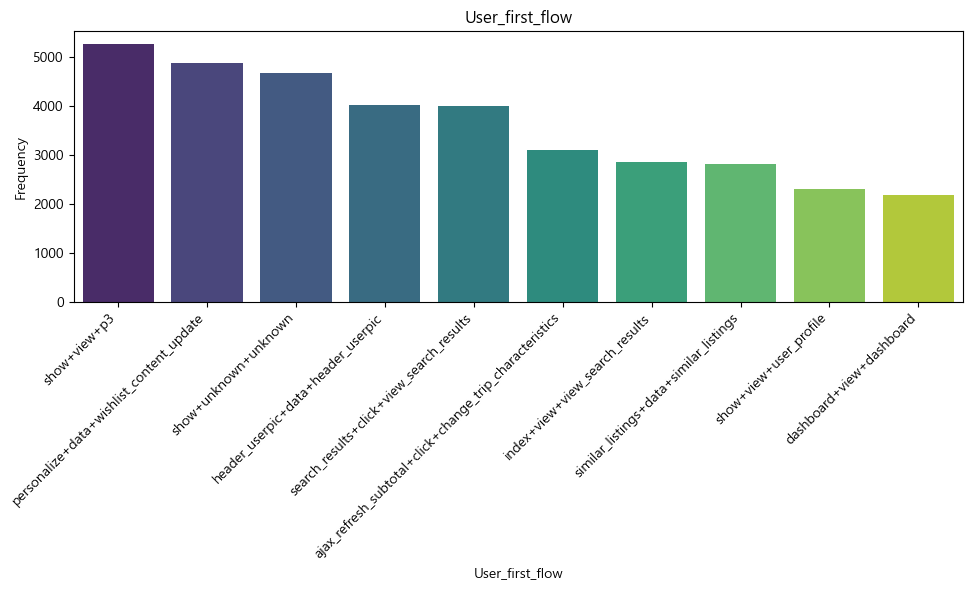

In [16]:
first_flow = new_sessions.groupby('user_id')['user_flow'].first().value_counts()[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=first_flow.index, y=first_flow.values, palette='viridis') 
plt.title('User_first_flow')
plt.xlabel('User_first_flow')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

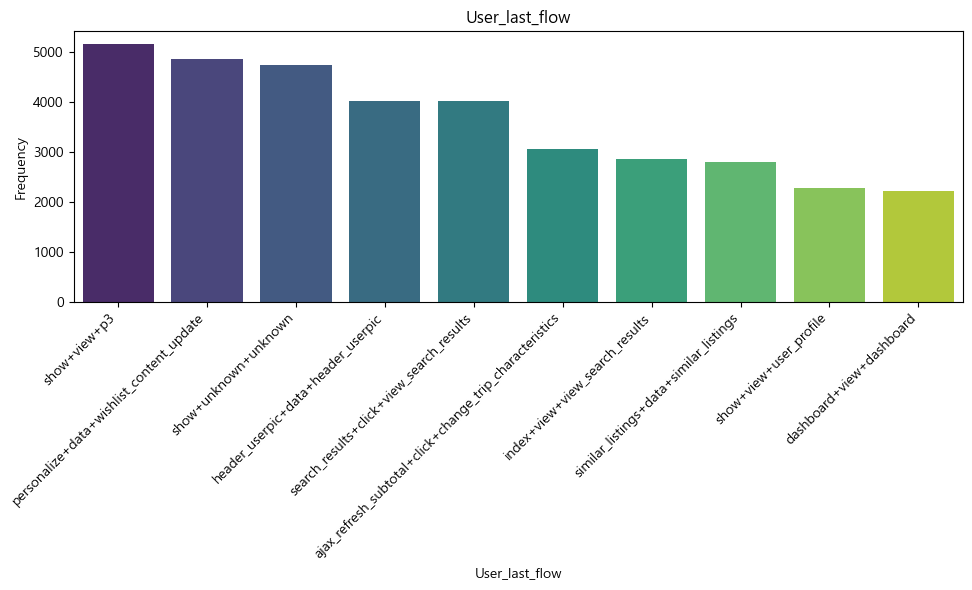

In [17]:
last_flow = new_sessions.groupby('user_id')['user_flow'].last().value_counts()[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=last_flow.index, y=last_flow.values, palette='viridis') 
plt.title('User_last_flow')
plt.xlabel('User_last_flow')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 예약 그룹의 flow 비교 
- reserved_group에 존재하는 id를 session에 남기고 flow확인

In [18]:
# 예약자 그룹과 비예약자 그룹 분할
reserved_group = df[df['binary_target'] == 1]
not_reserved_group = df[df['binary_target'] == 0]

In [19]:
# reserved_group의 user_id가 sessions의 user_id에 포함되어 있는지 판단
session_mask = sessions['user_id'].isin(reserved_group['user_id'])

## session에 포함된 user로 구성 (중복 x)
book_sessions = sessions[session_mask]
book_sessions.reset_index(drop=True, inplace=True)

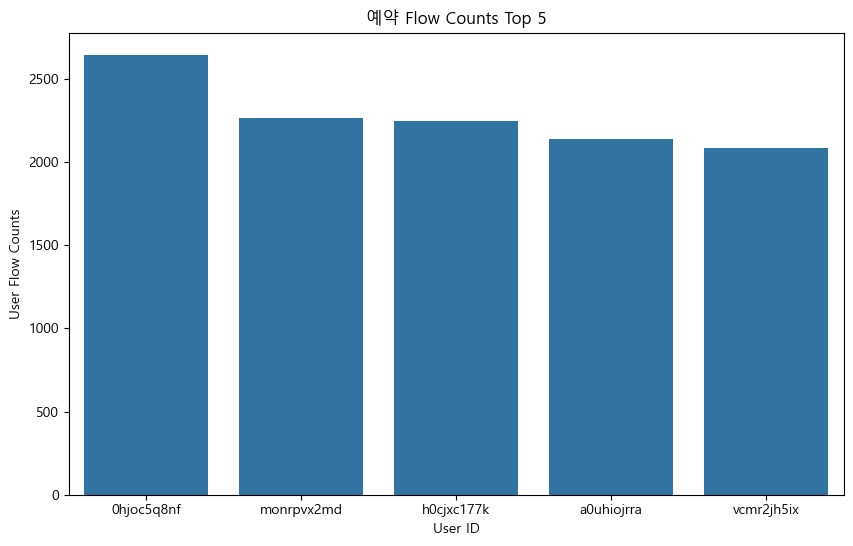

In [20]:
user_flow_counts = book_sessions.groupby('user_id')['user_flow'].size().reset_index()
user_flow_counts.columns = ['user_id', 'user_flow_counts']
user_flow_counts = user_flow_counts.sort_values(by='user_flow_counts', ascending=False)

# 상위 5개 
top_5_users = user_flow_counts.head()

top_5_users['user_id'] = top_5_users['user_id'].astype(str)

plt.figure(figsize=(10, 6))
sns.barplot(x='user_id', y='user_flow_counts', data=top_5_users)
plt.xlabel('User ID')
plt.ylabel('User Flow Counts')
plt.title('예약 Flow Counts Top 5')
plt.show()

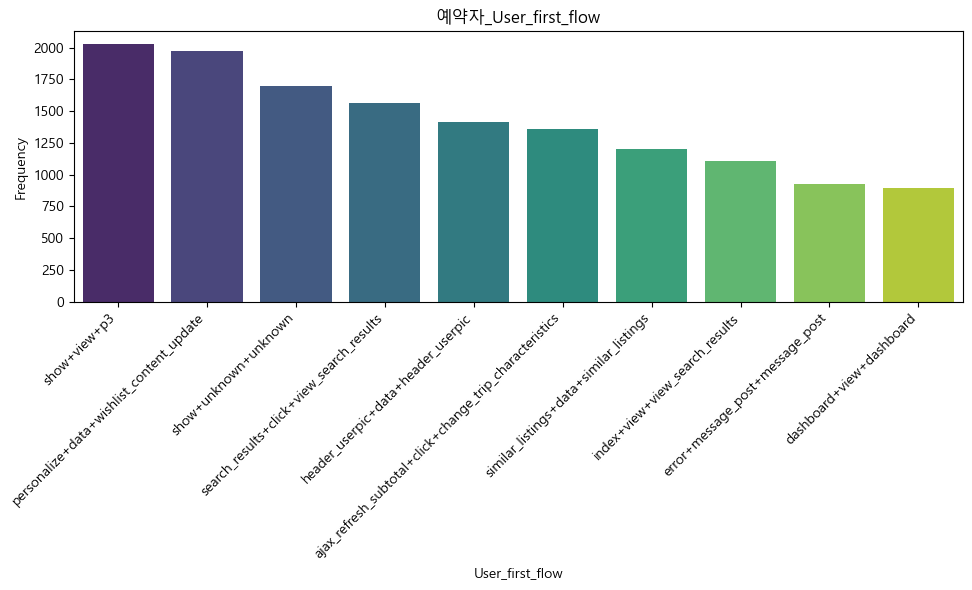

In [21]:
first_flow = book_sessions.groupby('user_id')['user_flow'].first().value_counts()[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=first_flow.index, y=first_flow.values, palette='viridis') 
plt.title('예약자_User_first_flow')
plt.xlabel('User_first_flow')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

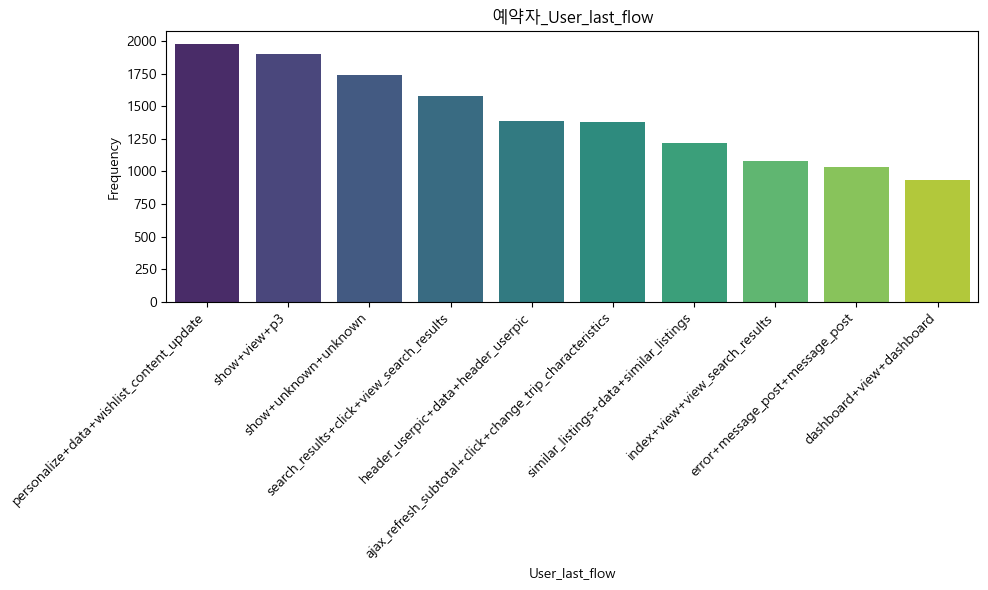

In [22]:
last_flow = book_sessions.groupby('user_id')['user_flow'].last().value_counts()[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=last_flow.index, y=last_flow.values, palette='viridis') 
plt.title('예약자_User_last_flow')
plt.xlabel('User_last_flow')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 예약하지 않은 그룹의 flow 개수

In [23]:
# reserved_group의 user_id가 sessions의 user_id에 포함되어 있는지 판단
session_mask = sessions['user_id'].isin(not_reserved_group['user_id'])

## session에 포함된 user로 구성 (중복 x)
not_book_sessions = sessions[session_mask]
not_book_sessions.reset_index(drop=True, inplace=True)

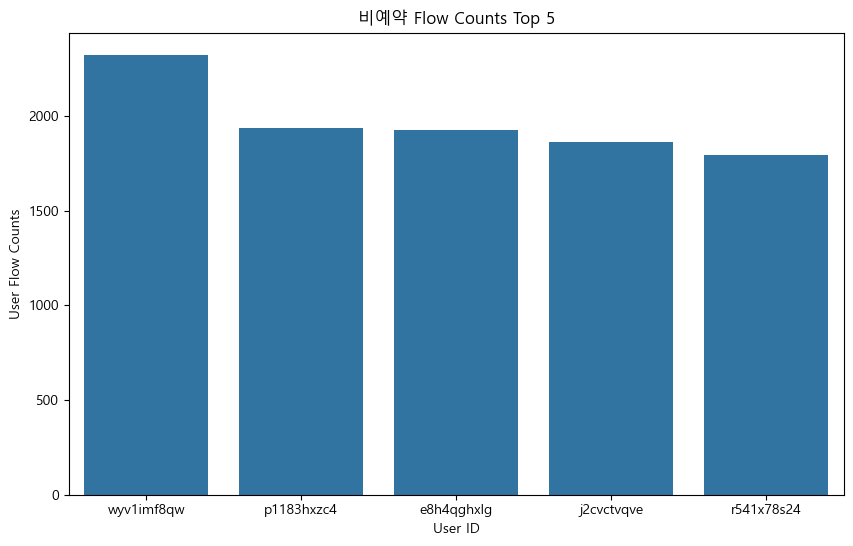

In [24]:
not_user_flow_counts = not_book_sessions.groupby('user_id')['user_flow'].size().reset_index()
not_user_flow_counts.columns = ['user_id', 'user_flow_counts']
not_user_flow_counts = not_user_flow_counts.sort_values(by='user_flow_counts', ascending=False)

# 상위 5개 
top_5_users = not_user_flow_counts.head()

top_5_users['user_id'] = top_5_users['user_id'].astype(str)

plt.figure(figsize=(10, 6))
sns.barplot(x='user_id', y='user_flow_counts', data=top_5_users)
plt.xlabel('User ID')
plt.ylabel('User Flow Counts')
plt.title('비예약 Flow Counts Top 5')
plt.show()

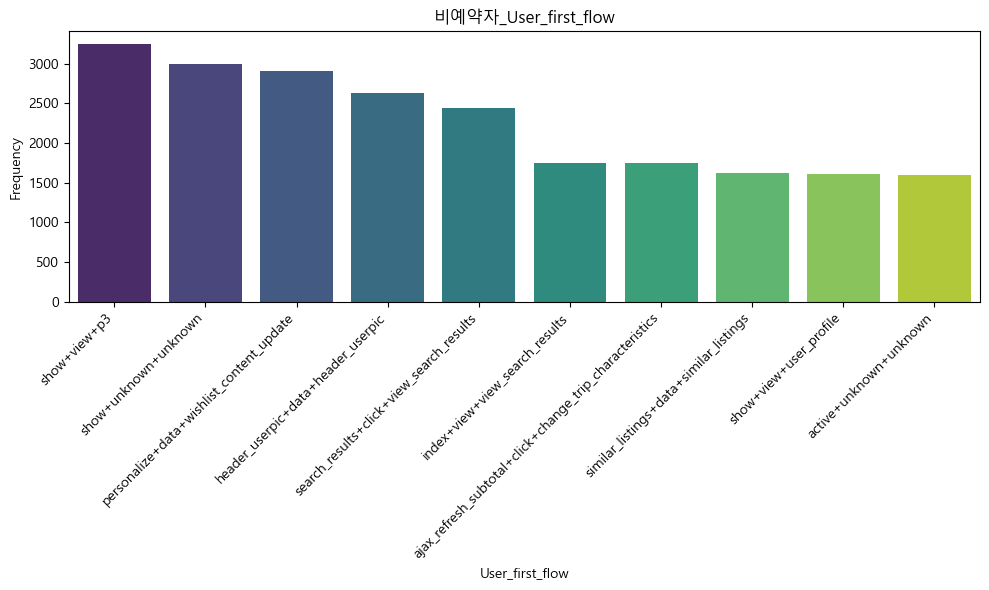

In [25]:
first_flow = not_book_sessions.groupby('user_id')['user_flow'].first().value_counts()[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=first_flow.index, y=first_flow.values, palette='viridis') 
plt.title('비예약자_User_first_flow')
plt.xlabel('User_first_flow')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

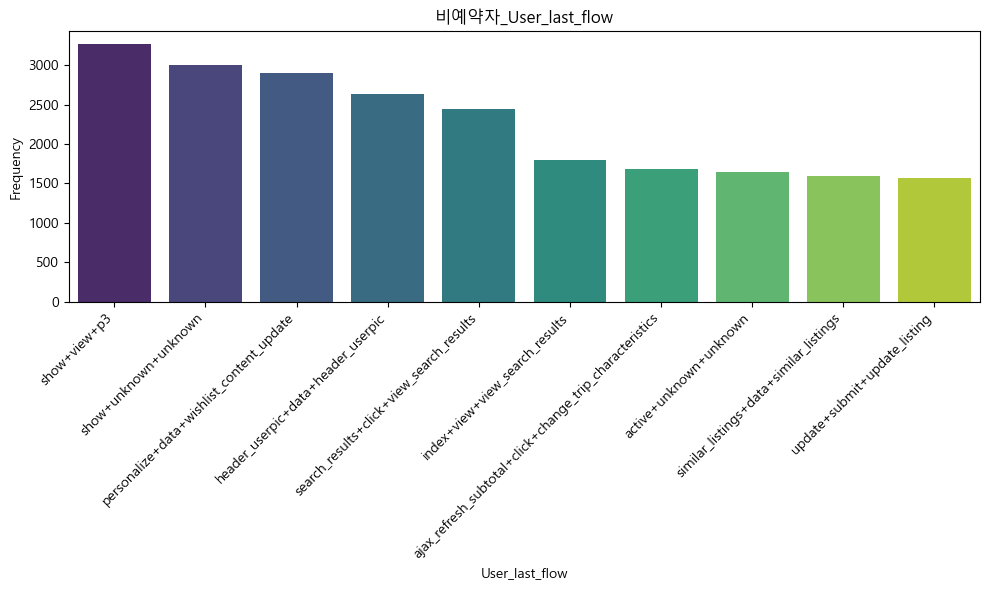

In [26]:
last_flow = not_book_sessions.groupby('user_id')['user_flow'].last().value_counts()[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=last_flow.index, y=last_flow.values, palette='viridis') 
plt.title('비예약자_User_last_flow')
plt.xlabel('User_last_flow')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 예약 vs 비예약 flow_counts 비교

In [27]:
not_user_flow_counts.describe()

,user_flow_counts
count,45041.000000
mean,67.887258
std,103.001028
min,1.000000
25%,11.000000
50%,33.000000
75%,83.000000
max,2323.000000


In [28]:
user_flow_counts.describe()

,user_flow_counts
count,28774.000000
mean,86.197505
std,125.225307
min,1.000000
25%,18.000000
50%,45.000000
75%,104.000000
max,2644.000000
